<a href="https://colab.research.google.com/github/Ark1645/Deep-Learning/blob/main/Binarynet_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BinaryNet on CIFAR10

<a href="https://colab.research.google.com/github/larq/docs/blob/master/docs/larq/tutorials/binarynet_cifar10.ipynb"><button class="notebook-badge">Run on Colab</button></a> <a href="https://github.com/larq/docs/blob/master/docs/larq/tutorials/binarynet_cifar10.ipynb"><button class="notebook-badge">View on GitHub</button></a>

In this example we demonstrate how to use Larq to build and train BinaryNet on the CIFAR10 dataset to achieve a validation accuracy approximately 83% on laptop hardware.
On a Nvidia GTX 1050 Ti Max-Q it takes approximately 200 minutes to train. For simplicity, compared to the original papers [BinaryConnect: Training Deep Neural Networks with binary weights during propagations](https://arxiv.org/abs/1511.00363), and [Binarized Neural Networks: Training Deep Neural Networks with Weights and Activations Constrained to +1 or -1](https://arxiv.org/abs/1602.02830), we do not impliment learning rate scaling, or image whitening.

In [9]:
pip install larq

In [10]:
import tensorflow as tf
import larq as lq
import numpy as np
import matplotlib.pyplot as plt

## Import CIFAR10 Dataset

We download and normalize the CIFAR10 dataset.

In [11]:
num_classes = 10

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

train_images = train_images.reshape((50000, 32, 32, 3)).astype("float32")
test_images = test_images.reshape((10000, 32, 32, 3)).astype("float32")

# Normalize pixel values to be between -1 and 1
train_images, test_images = train_images / 127.5 - 1, test_images / 127.5 - 1

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)

## Build BinaryNet

Here we build the BinaryNet model layer by layer using the [Keras Sequential API](https://www.tensorflow.org/guide/keras).

In [12]:
# All quantized layers except the first will use the same options
kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip",
              use_bias=False)

model = tf.keras.models.Sequential([
    # In the first layer we only quantize the weights and not the input
    lq.layers.QuantConv2D(128, 3,
                          kernel_quantizer="ste_sign",
                          kernel_constraint="weight_clip",
                          use_bias=False,
                          input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(128, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(256, 3, padding="same", **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(256, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(512, 3, padding="same", **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(512, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.Flatten(),

    lq.layers.QuantDense(1024, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantDense(1024, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantDense(10, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.Activation("softmax")
])

One can output a summary of the model:

In [13]:
lq.models.summary(model)

+sequential_1 stats--------------------------------------------------------------------------------------------+
| Layer                   Input prec.            Outputs   # 1-bit  # 32-bit   Memory  1-bit MACs  32-bit MACs |
|                               (bit)                          x 1       x 1     (kB)                          |
+--------------------------------------------------------------------------------------------------------------+
| quant_conv2d_6                    -  (-1, 30, 30, 128)      3456         0     0.42           0      3110400 |
| batch_normalization_9             -  (-1, 30, 30, 128)         0       256     1.00           0            0 |
| quant_conv2d_7                    1  (-1, 30, 30, 128)    147456         0    18.00   132710400            0 |
| max_pooling2d_3                   -  (-1, 15, 15, 128)         0         0        0           0            0 |
| batch_normalization_10            -  (-1, 15, 15, 128)         0       256     1.00           

## Model Training

Compile the model and train the model

In [17]:
model.compile(
    tf.keras.optimizers.legacy.Adam(learning_rate=0.01, decay=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [19]:
trained_model = model.fit(
    train_images,
    train_labels,
    batch_size=50,
    epochs=150,
    validation_data=(test_images, test_labels),
    shuffle=True
)

Epoch 1/150
1000/1000 [==============================] - 38s 38ms/step - loss: 0.7089 - accuracy: 0.8335 - val_loss: 1.0876 - val_accuracy: 0.6857
Epoch 2/150
1000/1000 [==============================] - 38s 38ms/step - loss: 0.6517 - accuracy: 0.8620 - val_loss: 0.9940 - val_accuracy: 0.7267
Epoch 3/150
1000/1000 [==============================] - 38s 38ms/step - loss: 0.6020 - accuracy: 0.8858 - val_loss: 0.9269 - val_accuracy: 0.7561
Epoch 4/150
1000/1000 [==============================] - 38s 38ms/step - loss: 0.5678 - accuracy: 0.9015 - val_loss: 0.8730 - val_accuracy: 0.7777
Epoch 5/150
1000/1000 [==============================] - 38s 38ms/step - loss: 0.5386 - accuracy: 0.9171 - val_loss: 0.9123 - val_accuracy: 0.7629
Epoch 6/150
1000/1000 [==============================] - 38s 38ms/step - loss: 0.5206 - accuracy: 0.9261 - val_loss: 0.8393 - val_accuracy: 0.7946
Epoch 7/150
1000/1000 [==============================] - 38s 38ms/step - loss: 0.4974 - accuracy: 0.9375 - val_loss: 0

## Model Output

We can now plot the final validation accuracy and loss:

0.9970200061798096
0.8341000080108643


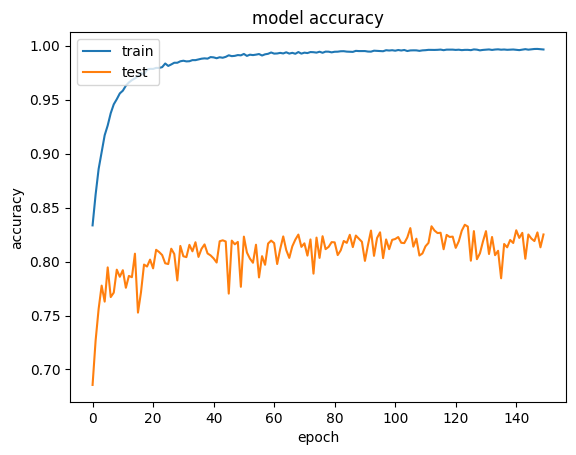

In [22]:
plt.plot(trained_model.history['accuracy'])
plt.plot(trained_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

print(np.max(trained_model.history['accuracy']))
print(np.max(trained_model.history['val_accuracy']))

0.3616035580635071
0.7730326056480408


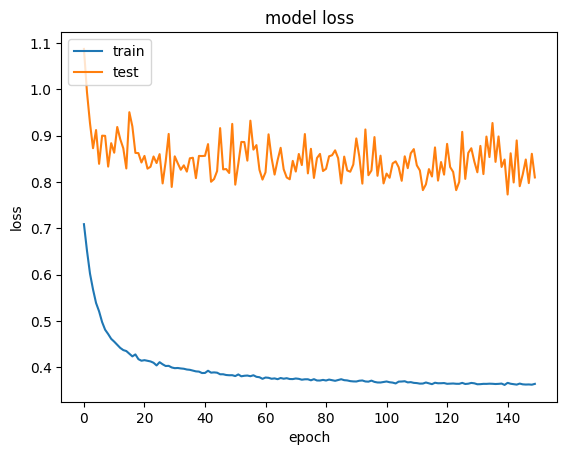

In [23]:
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

print(np.min(trained_model.history['loss']))
print(np.min(trained_model.history['val_loss']))

In [24]:
kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip",
              use_bias=False)

student_model = tf.keras.models.Sequential([
    # In the first layer we only quantize the weights and not the input
    lq.layers.QuantConv2D(32, 3,
                          kernel_quantizer="ste_sign",
                          kernel_constraint="weight_clip",
                          use_bias=False,
                          input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(64, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(128, 3, padding="same", **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(256, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    #lq.layers.QuantConv2D(512, 3, padding="same", **kwargs),
   # tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(512, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.Flatten(),

    lq.layers.QuantDense(1024, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantDense(256, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantDense(10, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.Activation("softmax")
    ],
        name="student",
  )

In [25]:
print(student_model.summary())

Model: "student"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quant_conv2d_12 (QuantConv  (None, 30, 30, 32)        864       
 2D)                                                             
                                                                 
 batch_normalization_18 (Ba  (None, 30, 30, 32)        96        
 tchNormalization)                                               
                                                                 
 quant_conv2d_13 (QuantConv  (None, 30, 30, 64)        18432     
 2D)                                                             
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization_19 (Ba  (None, 15, 15, 64)        192 

In [27]:
student_model.compile(
    tf.keras.optimizers.legacy.Adam(learning_rate=0.01, decay=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

## Change the name from trained_model to something else before executing as the previous model name is also trained model

In [29]:
trained_model = student_model.fit(
    train_images,
    train_labels,
    batch_size=50,
    epochs=100,
    validation_data=(test_images, test_labels),
    shuffle=True
)

Epoch 1/100
1000/1000 [==============================] - 18s 18ms/step - loss: 1.0865 - accuracy: 0.6699 - val_loss: 1.3790 - val_accuracy: 0.5495
Epoch 2/100
1000/1000 [==============================] - 18s 18ms/step - loss: 0.9479 - accuracy: 0.7306 - val_loss: 1.0884 - val_accuracy: 0.6762
Epoch 3/100
1000/1000 [==============================] - 17s 17ms/step - loss: 0.8617 - accuracy: 0.7673 - val_loss: 1.0225 - val_accuracy: 0.7129
Epoch 4/100
1000/1000 [==============================] - 17s 17ms/step - loss: 0.7901 - accuracy: 0.7994 - val_loss: 0.9466 - val_accuracy: 0.7338
Epoch 5/100
1000/1000 [==============================] - 17s 17ms/step - loss: 0.7356 - accuracy: 0.8244 - val_loss: 1.0220 - val_accuracy: 0.7056
Epoch 6/100
1000/1000 [==============================] - 17s 17ms/step - loss: 0.6940 - accuracy: 0.8440 - val_loss: 0.9488 - val_accuracy: 0.7374
Epoch 7/100
1000/1000 [==============================] - 17s 17ms/step - loss: 0.6615 - accuracy: 0.8606 - val_loss: 0

0.9832599759101868
0.7742999792098999


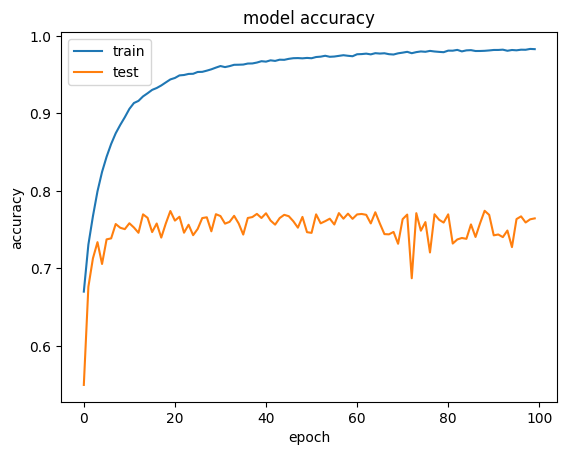

In [30]:
plt.plot(trained_model.history['accuracy'])
plt.plot(trained_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

print(np.max(trained_model.history['accuracy']))
print(np.max(trained_model.history['val_accuracy']))

0.4107151925563812
0.8848534226417542


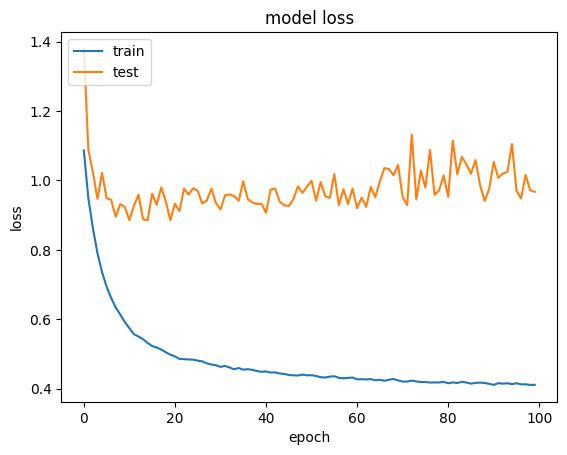

In [31]:
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

print(np.min(trained_model.history['loss']))
print(np.min(trained_model.history['val_loss']))